In [1]:
# --- Step 1: Import Libraries ---

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set plot style
plt.style.use('fivethirtyeight')

Fetching maximum available hourly data for TSLA (up to 730 days)...


C:\Users\INDIA\AppData\Local\Temp\ipykernel_21016\1220320542.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, period="730d", interval="1h")
[*********************100%***********************]  1 of 1 completed


Data downloaded successfully. Columns found:
MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])

Last 5 rows of data:
Price                           Close        High         Low        Open  \
Ticker                           TSLA        TSLA        TSLA        TSLA   
Datetime                                                                    
2025-08-08 19:30:00+00:00  329.679993  329.729889  327.220001  328.630005   
2025-08-11 13:30:00+00:00  341.334991  343.160004  334.149994  335.000000   
2025-08-11 14:30:00+00:00  344.070007  344.290009  340.299988  341.364990   
2025-08-11 15:30:00+00:00  346.390015  346.449005  343.399994  344.054993   
2025-08-11 16:30:00+00:00  344.665009  346.640015  344.299988  346.410004   

Price                        Volume  
Ticker                         TSLA  
Datetime                             
202

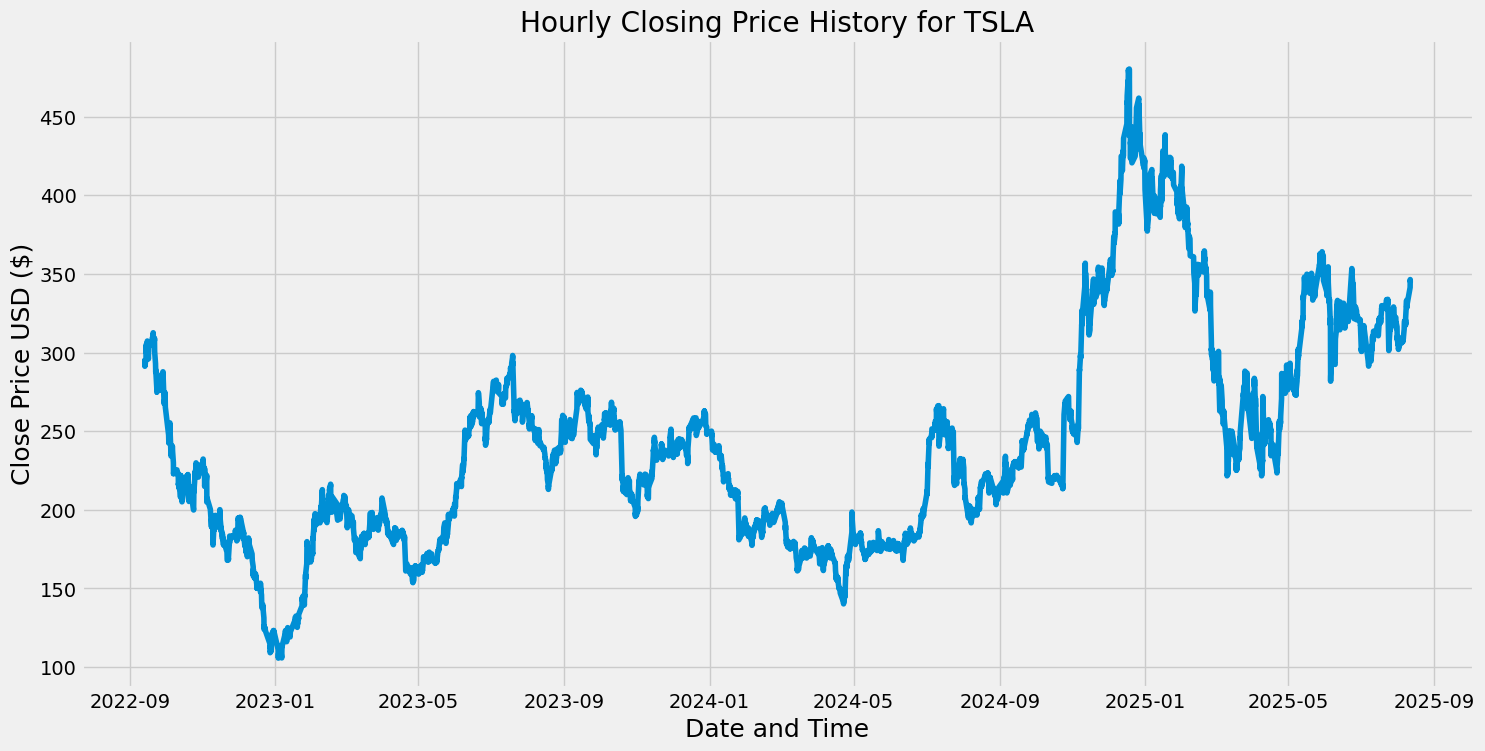

In [2]:
# --- Step 2: Fetch and Verify Hourly Data ---

# Define the ticker
TICKER = 'TSLA'

# For hourly data, yfinance limits the download to 730 days.
print(f"Fetching maximum available hourly data for {TICKER} (up to 730 days)...")
data = yf.download(TICKER, period="730d", interval="1h")

# --- !! IMPORTANT VERIFICATION STEP !! ---
if data.empty:
    print(f"Error: No data downloaded for ticker {TICKER}. It might be an invalid ticker or there's a network issue.")
    # Stop execution or handle the error appropriately in a real script
    # For a notebook, we'll print an error and the subsequent cells will fail as expected.
else:
    print("Data downloaded successfully. Columns found:")
    print(data.columns)
    print("\nLast 5 rows of data:")
    print(data.tail())

# Plot the closing price history (only if data is not empty)
if not data.empty:
    plt.figure(figsize=(16,8))
    plt.title(f'Hourly Closing Price History for {TICKER}')
    plt.plot(data['Close'])
    plt.xlabel('Date and Time', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.show()

Fetching maximum available hourly data for TSLA (730d)...


C:\Users\INDIA\AppData\Local\Temp\ipykernel_21016\3143176968.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval, progress=False)


Data fetched successfully. Original shape: (5079, 5) -> After dropna: (5079, 5)


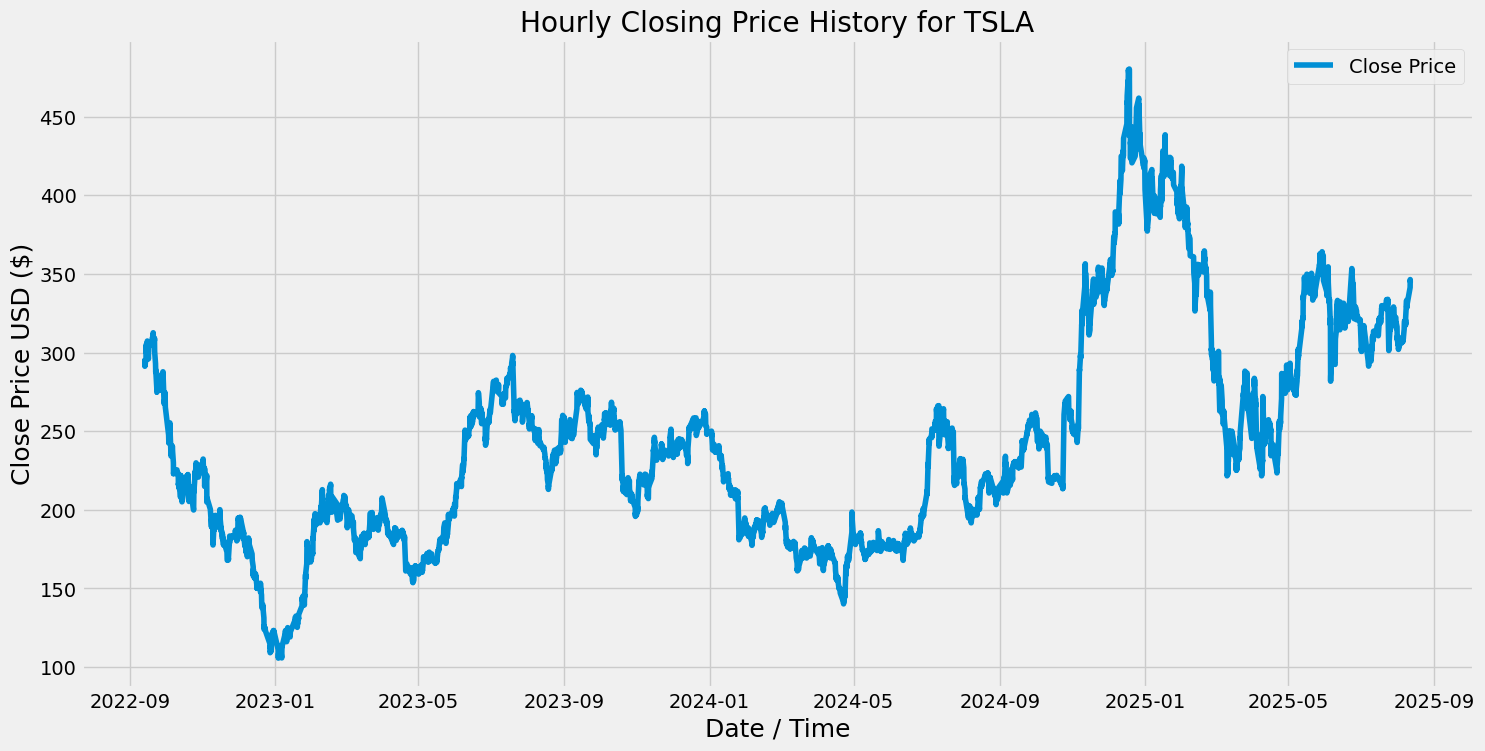

Preprocessing complete. Ready for model building/training.


In [4]:
# --- Combined Cell: Safe Fetch, Verify, and Preprocess Data ---

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Config
TICKER = 'TSLA'
PERIOD = "730d"
INTERVAL = "1h"
TIME_STEP = 60

print(f"Fetching maximum available hourly data for {TICKER} ({PERIOD})...")

def safe_fetch(ticker, period, interval):
    try:
        df = yf.download(ticker, period=period, interval=interval, progress=False)
    except Exception as e:
        raise RuntimeError(f"Download failed for {ticker}: {e}")

    if df.empty:
        raise ValueError(f"No data returned for {ticker} with period={period}, interval={interval}")

    # Drop NaNs and check again
    original_shape = df.shape
    df.dropna(inplace=True)
    if df.empty:
        raise ValueError(f"After dropping NaNs, no usable data remains for {ticker}")

    print(f"Data fetched successfully. Original shape: {original_shape} -> After dropna: {df.shape}")
    return df

try:
    data = safe_fetch(TICKER, PERIOD, INTERVAL)

    if 'Close' not in data.columns:
        raise KeyError(f"'Close' column missing. Columns available: {list(data.columns)}")

    # Plot closing prices
    plt.figure(figsize=(16, 8))
    plt.title(f'Hourly Closing Price History for {TICKER}')
    plt.plot(data['Close'], label='Close Price')
    plt.xlabel('Date / Time', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.legend()
    plt.show()

    # Prepare close price dataset
    close_data = data[['Close']]
    dataset = close_data.values

    # Scale safely
    if dataset.shape[0] < TIME_STEP:
        raise ValueError(f"Not enough data to create sequences (got {dataset.shape[0]} rows, need at least {TIME_STEP})")

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_dataset = scaler.fit_transform(dataset)

    print("Preprocessing complete. Ready for model building/training.")

except (ValueError, KeyError, RuntimeError) as err:
    print(f"CRITICAL ERROR: {err}")


In [5]:
# --- Cell 4: Create Training and Test Datasets ---

# We'll use the variables created in your previous cell:
# scaled_dataset, dataset, TIME_STEP

# Split the data into training (80%) and test (20%) sets
training_data_len = int(np.ceil(len(scaled_dataset) * 0.8))

# Create the training dataset
train_data = scaled_dataset[0:training_data_len, :]
x_train, y_train = [], []
for i in range(TIME_STEP, len(train_data)):
    x_train.append(train_data[i-TIME_STEP:i, 0])
    y_train.append(train_data[i, 0])

# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for the LSTM model [samples, time_steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(f"Shape of training data (x_train): {x_train.shape}")


# Create the testing dataset
# We need the last TIME_STEP values from the training set to start the test set
test_data = scaled_dataset[training_data_len - TIME_STEP:, :]
x_test = []
y_test = dataset[training_data_len:, :] # Use the original (unscaled) values for comparison

for i in range(TIME_STEP, len(test_data)):
    x_test.append(test_data[i-TIME_STEP:i, 0])
    
# Convert to numpy array and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(f"Shape of test data (x_test): {x_test.shape}")
print(f"Shape of actual test values (y_test): {y_test.shape}")

Shape of training data (x_train): (4004, 60, 1)
Shape of test data (x_test): (1015, 60, 1)
Shape of actual test values (y_test): (1015, 1)


In [ ]:
# --- Cell 5: Build, Train, and Save the LSTM Model ---

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define a unique filename for the hourly model
MODEL_PATH = f"{TICKER}_hourly_lstm_model.keras"

# Define Hyperparameters
lstm_units = 50
dropout_rate = 0.2
epochs = 25
batch_size = 32

print(f"\nBuilding LSTM model... This might take a moment.")
model = Sequential([
    LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(dropout_rate),
    LSTM(units=lstm_units, return_sequences=False),
    Dropout(dropout_rate),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
print(f"Training model for {epochs} epochs...")
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

# Save the trained model to disk
model.save(MODEL_PATH)
print(f"\nModel training complete. Model saved to: {MODEL_PATH}")
model.summary()

In [6]:
# --- UPDATED Cell 5: Hyperparameter Tuning with Additional Metrics ---

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner

# 1. DEFINE THE MODEL-BUILDING FUNCTION
# This function tells Keras Tuner HOW to build the model for each trial.
def build_model(hp):
    model = Sequential()
    
    # Tune the number of units in the first LSTM layer
    hp_units = hp.Int('units', min_value=32, max_value=128, step=16)
    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.05)
    
    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(hp_dropout))
    
    # Using the same tuned values for the second layer for simplicity
    model.add(LSTM(units=hp_units, return_sequences=False))
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # --- THIS IS THE MODIFIED LINE ---
    # We add 'mean_absolute_error' to the metrics list.
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='mean_squared_error',
        metrics=['mean_absolute_error'] # <-- ADDED METRIC
    )
    
    return model

# 2. INSTANTIATE THE TUNER
# The objective for val_loss is still correct as we want to minimize the primary loss function.
tuner = keras_tuner.Hyperband(
    build_model,
    objective='val_loss', 
    max_epochs=25,
    factor=3,
    directory='stock_tuning_dir',
    project_name=f'{TICKER}_hourly_tuning_with_mae' # New project name to avoid conflicts
)

# 3. RUN THE SEARCH
print("Starting hyperparameter search... This will take a significant amount of time.")
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# The tuner will automatically use a portion of the training data for validation.
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early], verbose=1)

# 4. RETRIEVE THE BEST HYPERPARAMETERS
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hyperparameter search complete.
The optimal number of units in the LSTM layers is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout'):.3f}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# 5. BUILD AND TRAIN THE FINAL MODEL
print("\nBuilding the final model with the best hyperparameters...")
model = tuner.hypermodel.build(best_hps)

print("Training the final model on the entire training dataset...")
history = model.fit(
    x_train, 
    y_train, 
    epochs=25,
    validation_split=0.2, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)]
)

# 6. SAVE THE OPTIMIZED MODEL
MODEL_PATH = f"{TICKER}_hourly_lstm_model_tuned.keras"
model.save(MODEL_PATH)
print(f"\nOptimized model training complete. Model saved to: {MODEL_PATH}")
model.summary()

Trial 30 Complete [00h 03m 44s]
val_loss: 0.0005706888623535633

Best val_loss So Far: 0.00019711494678631425
Total elapsed time: 01h 06m 46s

Hyperparameter search complete.
The optimal number of units in the LSTM layers is 128.
The optimal dropout rate is 0.100.
The optimal learning rate for the optimizer is 0.001.


Building the final model with the best hyperparameters...
Training the final model on the entire training dataset...
Epoch 1/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 222ms/step - loss: 0.0036 - mean_absolute_error: 0.0344 - val_loss: 8.1772e-04 - val_mean_absolute_error: 0.0205
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - loss: 4.2834e-04 - mean_absolute_error: 0.0159 - val_loss: 7.3434e-04 - val_mean_absolute_error: 0.0189
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - loss: 3.6522e-04 - mean_absolute_error: 0.0147 - val_loss: 6.7050e-04 - val_mean_absolute_error: 0.0179
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - loss: 3.6200e-04 - mean_ab

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         3,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,187 (2.30 MB)

 Trainable params: 201,395 (786.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 402,792 (1.54 MB)

--- Comprehensive Model Evaluation ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step
Root Mean Squared Error (RMSE):        $6.13
Mean Absolute Error (MAE):           $4.23
Mean Absolute Percentage Error (MAPE): 1.41%
Accuracy (within ±1%):              54.19%
R-squared (R²):                      0.9850
Adjusted R-squared:                  0.9841
Explained Variance Score:            0.9852
Max Error:                           $30.02
----------------------------------------

Visualizing the prediction results...


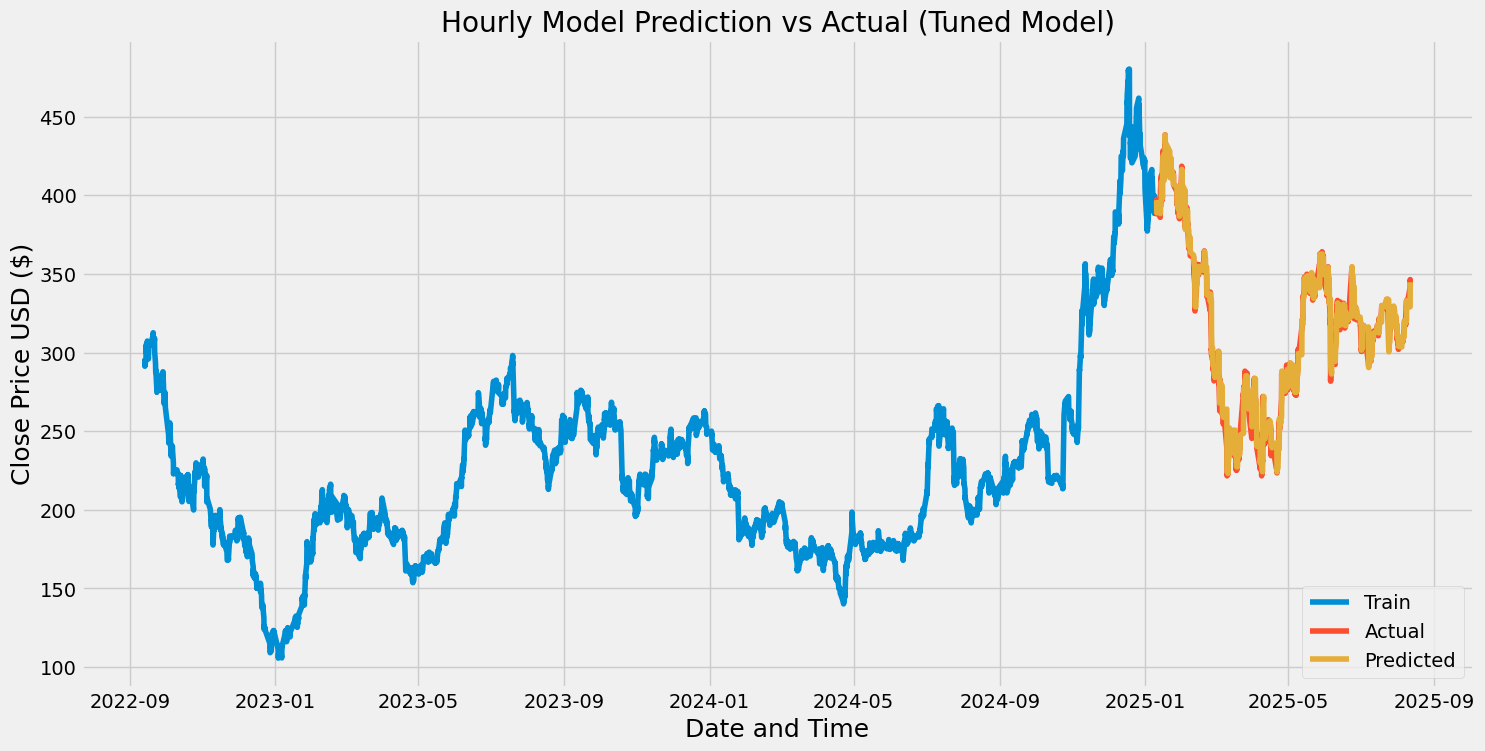


Last 5 Predictions vs Actual Prices:
Price                           Close Predictions
Ticker                           TSLA            
Datetime                                         
2025-08-08 19:30:00+00:00  329.679993  329.559875
2025-08-11 13:30:00+00:00  341.334991  329.035919
2025-08-11 14:30:00+00:00  344.070007  333.518524
2025-08-11 15:30:00+00:00  346.390015  339.488556
2025-08-11 16:30:00+00:00  344.619995  344.677063


In [7]:
# --- Step 6: Evaluate Model with Advanced Metrics and Visualize Results ---

# Import all necessary metrics from scikit-learn
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             r2_score,
                             explained_variance_score,
                             max_error)

print("--- Comprehensive Model Evaluation ---")
# Make predictions on the test set
# This uses the 'model' and 'x_test' variables from the previous cells
predictions = model.predict(x_test)
# Un-scale the predictions back to their original dollar values
predictions = scaler.inverse_transform(predictions)

# --- CALCULATE AND DISPLAY PERFORMANCE METRICS ---

# 1. Root Mean Squared Error (RMSE)
# Measures the standard deviation of the prediction errors. Sensitive to large errors.
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE):        ${rmse:.2f}')

# 2. Mean Absolute Error (MAE)
# The average absolute error in dollars. Very interpretable.
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE):           ${mae:.2f}')

# 3. Mean Absolute Percentage Error (MAPE)
# The average prediction error in percentage terms.
epsilon = 1e-10
mape = mean_absolute_percentage_error(y_test + epsilon, predictions)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')

# 4. Custom Prediction Accuracy (%)
# The percentage of predictions that fall within a ±1% tolerance of the actual price.
tolerance = 0.01
accurate_predictions = np.abs((predictions - y_test) / (y_test + epsilon)) <= tolerance
accuracy_within_tolerance = np.mean(accurate_predictions) * 100
print(f'Accuracy (within ±{tolerance:.0%}):              {accuracy_within_tolerance:.2f}%')

# 5. R-squared (R²)
# Proportion of the variance in the actual prices that is predictable from the model.
r2 = r2_score(y_test, predictions)
print(f'R-squared (R²):                      {r2:.4f}')

# 6. Adjusted R-squared
# R-squared adjusted for the number of predictors (our time steps).
n = len(y_test)
p = x_test.shape[1] # This is equal to TIME_STEP
if (n - p - 1) == 0:
    adj_r2 = np.nan
else:
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared:                  {adj_r2:.4f}')

# 7. Explained Variance Score
# Measures how well the model accounts for the dataset's variation. 1.0 is perfect.
explained_variance = explained_variance_score(y_test, predictions)
print(f'Explained Variance Score:            {explained_variance:.4f}')

# 8. Max Error
# The single worst prediction error (in dollars) in the test set.
max_err = max_error(y_test, predictions)
print(f'Max Error:                           ${max_err:.2f}')

print("-" * 40)

# --- VISUALIZE THE RESULTS ---
print("\nVisualizing the prediction results...")

# Prepare data for plotting using variables from earlier cells
train = close_data[:training_data_len]
valid = close_data[training_data_len:].copy() # Use .copy() to avoid SettingWithCopyWarning
valid['Predictions'] = predictions

# Create the plot
plt.figure(figsize=(16, 8))
plt.title('Hourly Model Prediction vs Actual (Tuned Model)')
plt.xlabel('Date and Time', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='Actual Price')
plt.plot(valid['Predictions'], label='Predicted Price')
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()

# Display the last few predicted vs actual values for a direct comparison
print("\nLast 5 Predictions vs Actual Prices:")
print(valid[['Close', 'Predictions']].tail())